In [ ]:
 
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
 
from tqdm import tqdm
from sklearn.preprocessing import (
    PowerTransformer,
    StandardScaler,
    label_binarize
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
   
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
sns.set_theme(style="whitegrid")


In [2]:
df=pd.read_csv("Combined Data\Combined_dataset.csv")

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\O\AppData\Local\Temp\ipykernel_4824\468677050.py:1: SyntaxWarning: invalid escape sequence '\C'
  df=pd.read_csv("Combined Data\Combined_dataset.csv")


In [3]:
df.head()

,Country,Area,Waterbody Type,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),Nitrate (mg/l),CCME_Values,CCME_WQI
0,Canada,SE649035-145565,River,12-01-1974,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,11.73155,100.0,Excellent
1,Canada,SE649035-145565,River,12-01-1975,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,11.82009,100.0,Excellent
2,Canada,SE649035-145565,River,12-01-1976,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,14.87472,100.0,Excellent
3,Canada,SE649035-145565,River,12-01-1977,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,15.89293,100.0,Excellent
4,Canada,SE649035-145565,River,12-01-1978,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,15.22888,100.0,Excellent


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2827977 entries, 0 to 2827976
Data columns (total 14 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Country                           object 
 1   Area                              object 
 2   Waterbody Type                    object 
 3   Date                              object 
 4   Ammonia (mg/l)                    float64
 5   Biochemical Oxygen Demand (mg/l)  float64
 6   Dissolved Oxygen (mg/l)           float64
 7   Orthophosphate (mg/l)             float64
 8   pH (ph units)                     float64
 9   Temperature (cel)                 float64
 10  Nitrogen (mg/l)                   float64
 11  Nitrate (mg/l)                    float64
 12  CCME_Values                       float64
 13  CCME_WQI                          object 
dtypes: float64(9), object(5)
memory usage: 302.1+ MB


In [5]:
df.isnull().sum()

Country                             0
Area                                0
Waterbody Type                      0
Date                                0
Ammonia (mg/l)                      0
Biochemical Oxygen Demand (mg/l)    0
Dissolved Oxygen (mg/l)             0
Orthophosphate (mg/l)               0
pH (ph units)                       0
Temperature (cel)                   0
Nitrogen (mg/l)                     0
Nitrate (mg/l)                      0
CCME_Values                         0
CCME_WQI                            0
dtype: int64

In [6]:
df["CCME_WQI"].value_counts()

CCME_WQI
Good         1033709
Excellent    1020710
Marginal      328734
Fair          317856
Poor          126968
Name: count, dtype: int64

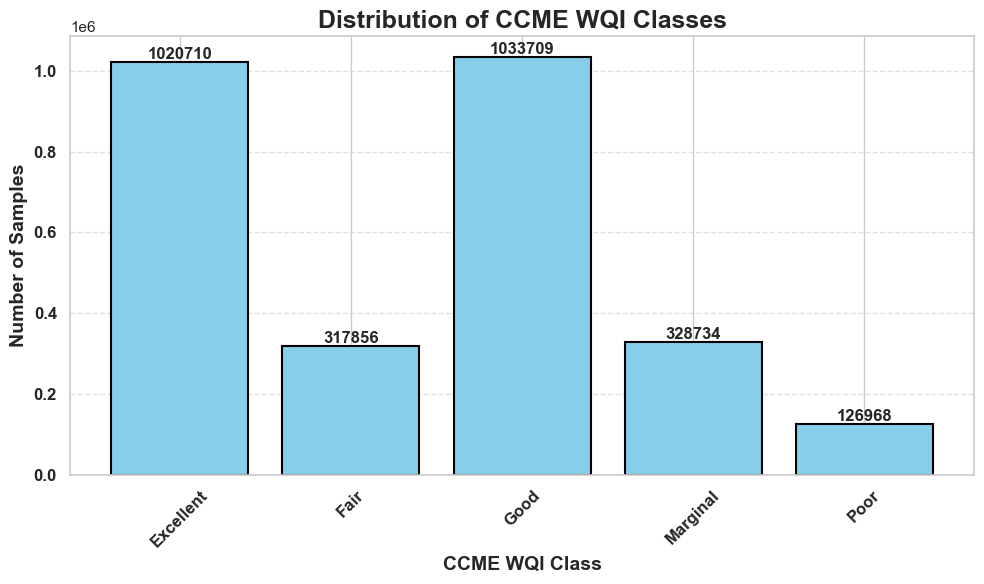

In [7]:
 
distribution = df["CCME_WQI"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(
    distribution.index,
    distribution.values,
    color="skyblue",
    edgecolor="black",
    linewidth=1.5
)

 
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   
        height + 0.5,                      
        f'{int(height)}',                 
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.title("Distribution of CCME WQI Classes", fontsize=18, fontweight="bold")
plt.xlabel("CCME WQI Class", fontsize=14, fontweight="bold")
plt.ylabel("Number of Samples", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold", rotation=45)
plt.yticks(fontsize=12, fontweight="bold")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [8]:
corr_data=df.select_dtypes(include="number").corr()

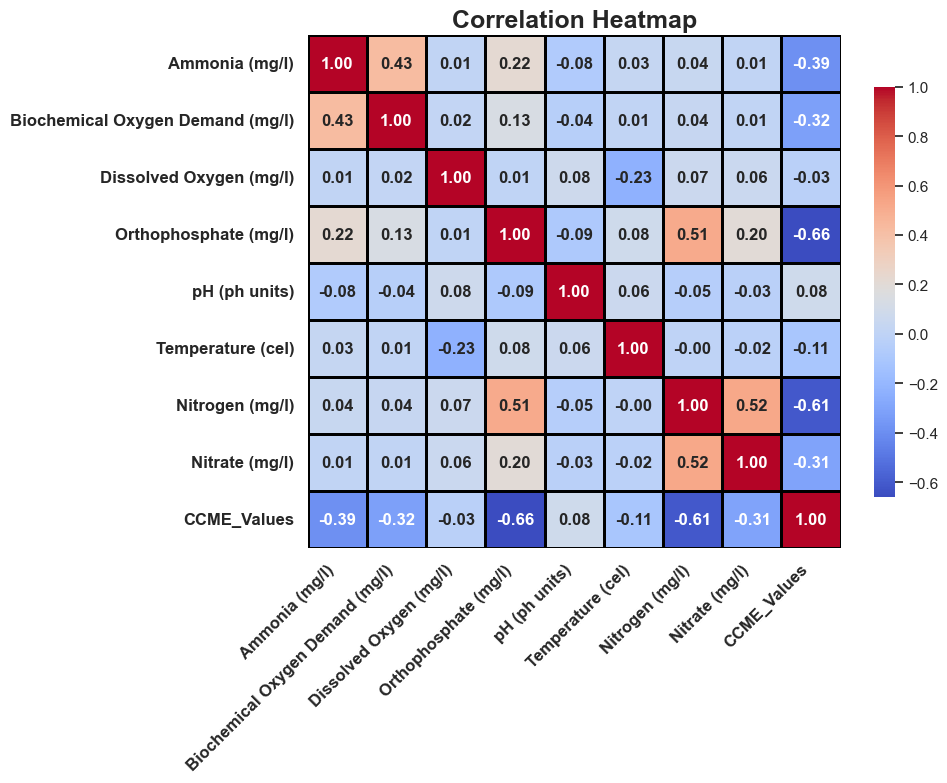

In [9]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr_data,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 12, "weight": "bold"},
    linewidths=1,
    linecolor="black",
    cbar_kws={"shrink": 0.8}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    fontsize=12,
    fontweight="bold",
    rotation=45,
    ha="right"
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=12,
    fontweight="bold",
    rotation=0
)
plt.title("Correlation Heatmap", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()


In [10]:
df.duplicated().sum()

np.int64(9971)

In [11]:
df[df.duplicated()]
duplicates_grouped = df.groupby(list(df.columns)).size().reset_index(name='count')
duplicates_grouped[duplicates_grouped['count'] > 1]

,Country,Area,Waterbody Type,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),Nitrate (mg/l),CCME_Values,CCME_WQI,count
94,Canada,CHRW-1339,River,12-01-2005,0.051060,0.930000,10.2160,0.0127,8.3167,10.9500,1.664290,5.245995,100.000000,Excellent,2
95,Canada,CHRW-1345,River,12-01-1999,0.137558,1.520000,10.5250,0.0124,8.3133,19.6667,1.245670,4.249920,100.000000,Excellent,2
96,Canada,CHRW-1345,River,12-01-2000,0.121072,1.500000,10.2500,0.1022,8.1975,11.6583,0.636642,4.382730,91.774842,Good,2
97,Canada,CHRW-1345,River,12-01-2001,0.177699,1.545390,9.0750,0.0230,8.1725,11.4250,12.500000,13.731226,100.000000,Excellent,2
98,Canada,CHRW-1345,River,12-01-2002,0.052107,0.558333,10.2167,0.0114,8.1700,10.7583,0.636364,5.091050,100.000000,Excellent,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817361,USA,Yuba,River,16-01-1962,0.021000,1.600000,9.8700,0.0400,7.8000,11.1000,0.400000,0.900000,100.000000,Excellent,2
2817416,USA,Yuba,River,16-12-1976,0.021000,1.600000,9.8700,0.0400,7.8000,11.1000,0.400000,0.900000,100.000000,Excellent,2
2817527,USA,Yuba,River,20-02-1962,0.021000,1.600000,9.8700,0.0400,7.3000,11.1000,0.400000,0.900000,100.000000,Excellent,2
2817531,USA,Yuba,River,20-02-2003,0.021000,1.600000,9.8700,0.0400,7.8000,1.4000,0.400000,0.900000,100.000000,Excellent,2


In [12]:
df.isna().sum()

Country                             0
Area                                0
Waterbody Type                      0
Date                                0
Ammonia (mg/l)                      0
Biochemical Oxygen Demand (mg/l)    0
Dissolved Oxygen (mg/l)             0
Orthophosphate (mg/l)               0
pH (ph units)                       0
Temperature (cel)                   0
Nitrogen (mg/l)                     0
Nitrate (mg/l)                      0
CCME_Values                         0
CCME_WQI                            0
dtype: int64

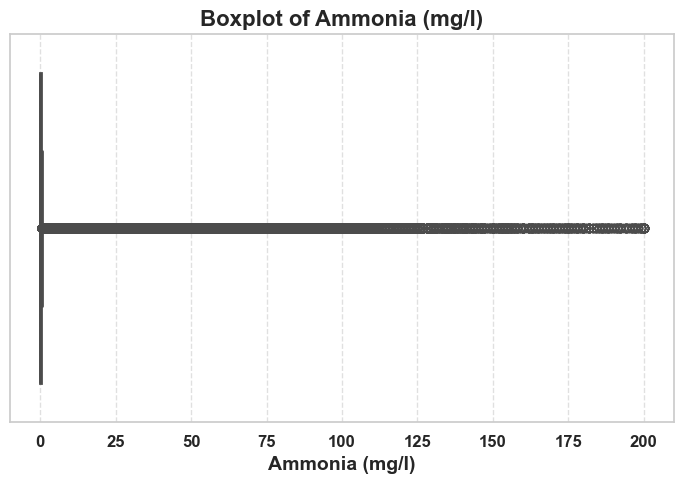

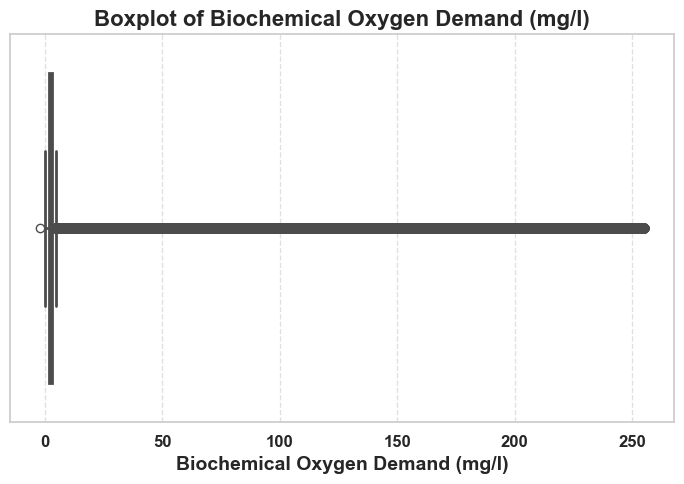

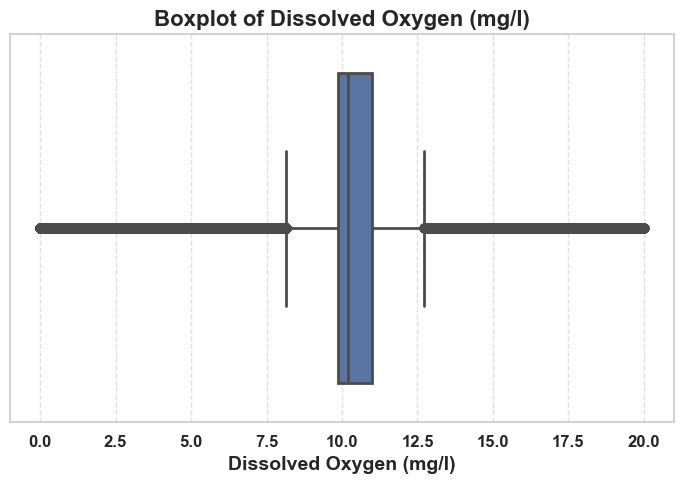

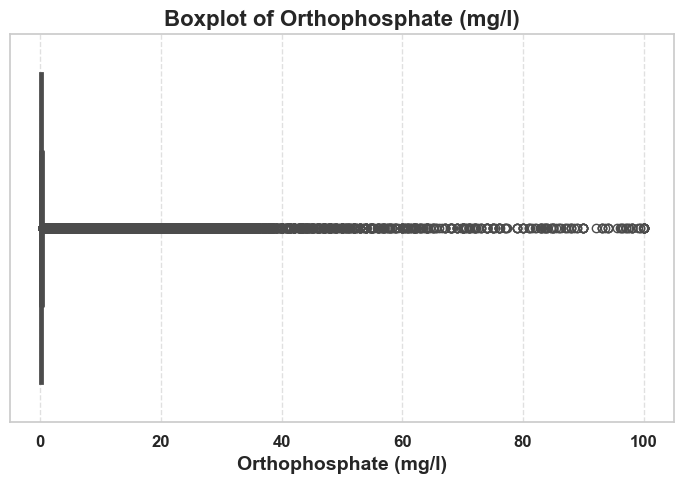

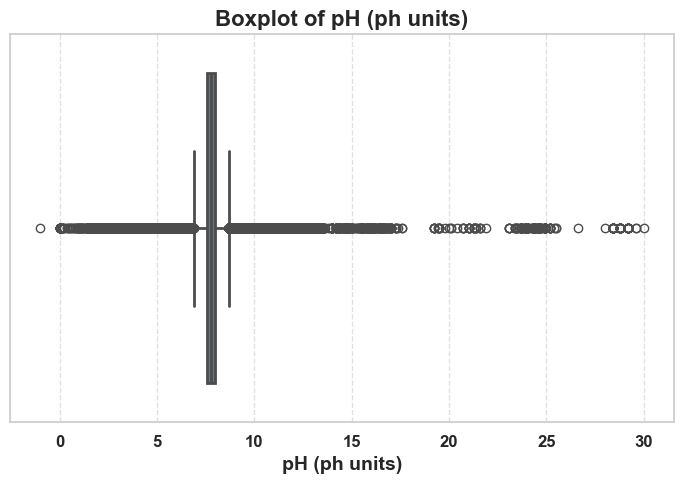

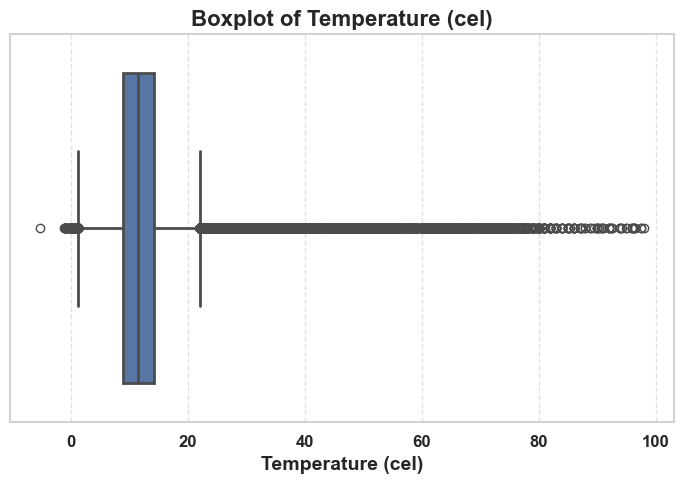

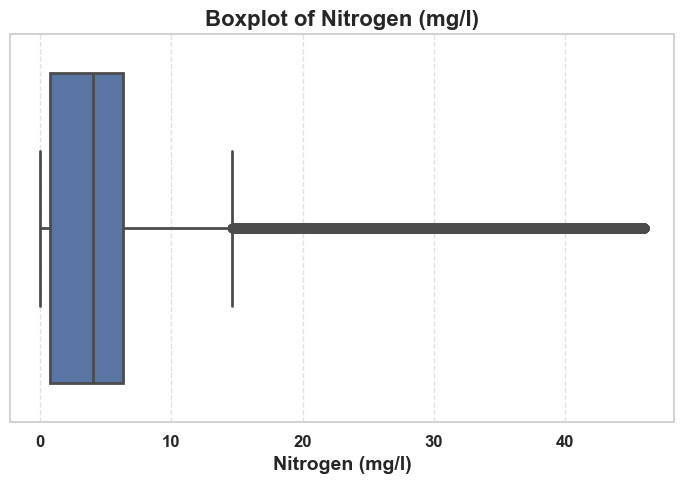

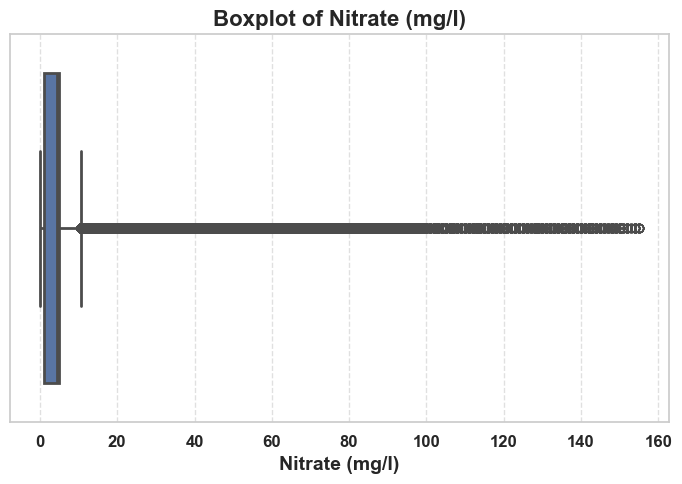

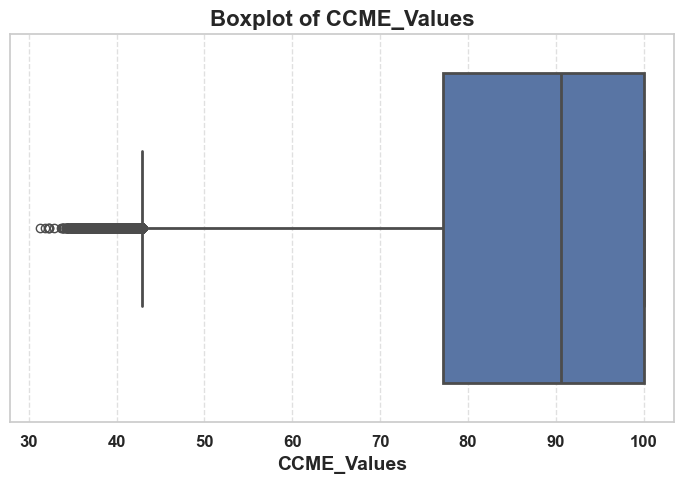

In [13]:
numeric_cols = df.select_dtypes(include="number").columns

for col in numeric_cols:
    plt.figure(figsize=(7, 5))

    ax = sns.boxplot(
        x=df[col],
        linewidth=2
    )
    ax.set_title(
        f"Boxplot of {col}",
        fontsize=16,
        fontweight="bold"
    )
    ax.set_xlabel(
        col,
        fontsize=14,
        fontweight="bold"
    )
    ax.tick_params(axis='x', labelsize=12)
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')

   
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


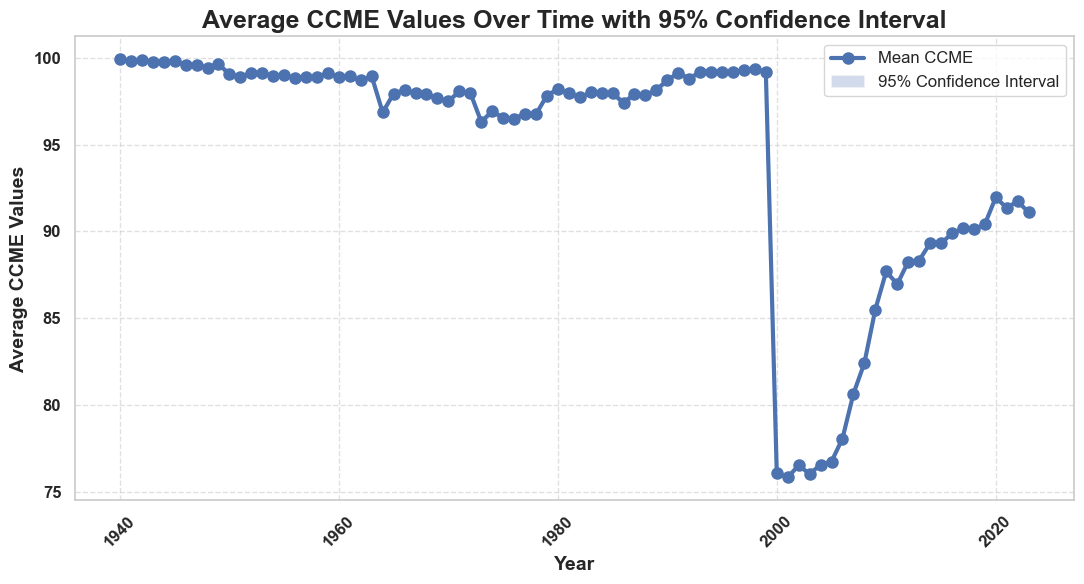

In [14]:
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df["CCME_Values"] = pd.to_numeric(df["CCME_Values"], errors="coerce")
df["Year"] = df["Date"].dt.year
agg = df.groupby("Year")["CCME_Values"].agg(["mean", "std", "count"]).dropna()
agg["sem"] = agg["std"] / np.sqrt(agg["count"])
agg["ci95_low"] = agg["mean"] - 1.96 * agg["sem"]
agg["ci95_high"] = agg["mean"] + 1.96 * agg["sem"]
plt.figure(figsize=(11, 6))
plt.plot(
    agg.index,
    agg["mean"],
    marker="o",
    linewidth=3,
    markersize=8,
    label="Mean CCME"
)

plt.fill_between(
    agg.index,
    agg["ci95_low"],
    agg["ci95_high"],
    alpha=0.25,
    label="95% Confidence Interval"
) 
plt.xlabel("Year", fontsize=14, fontweight="bold")
plt.ylabel("Average CCME Values", fontsize=14, fontweight="bold")
plt.title(
    "Average CCME Values Over Time with 95% Confidence Interval",
    fontsize=18,
    fontweight="bold"
)
plt.xticks(fontsize=12, fontweight="bold", rotation=45)
plt.yticks(fontsize=12, fontweight="bold") 
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


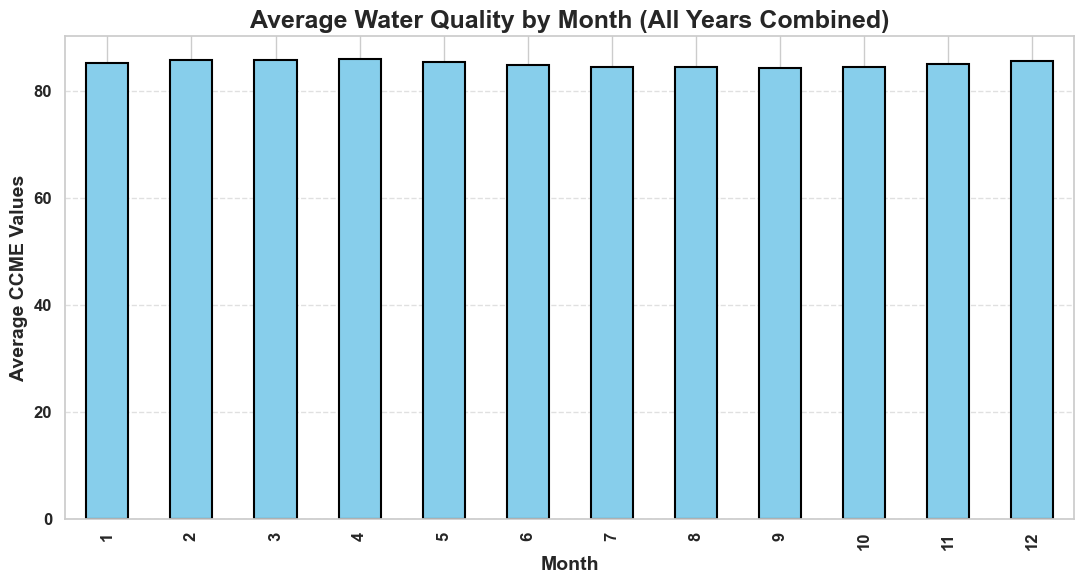

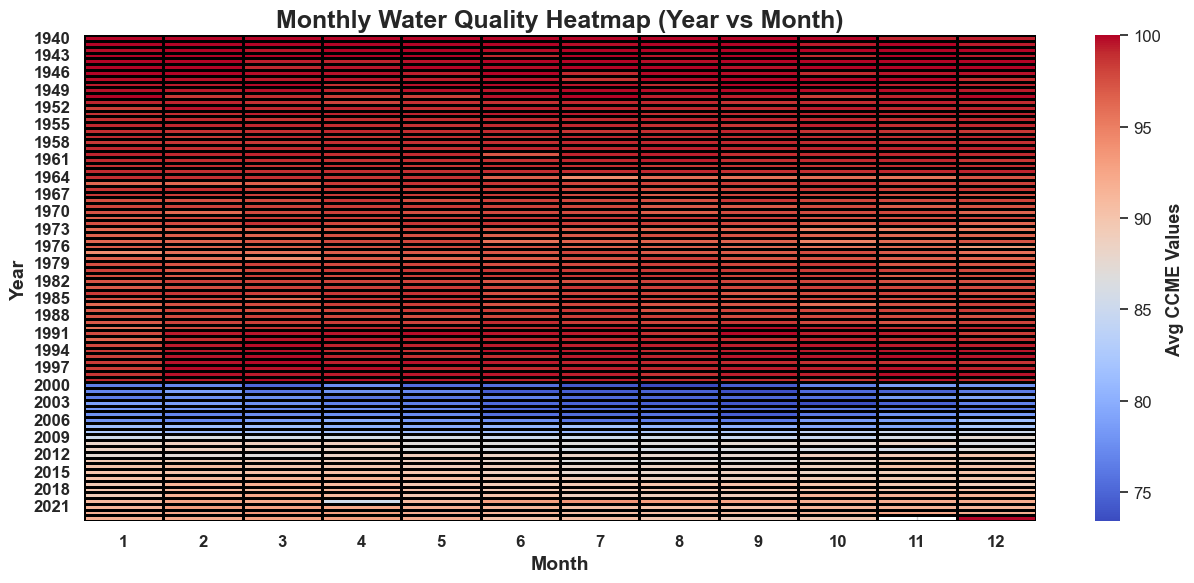

In [15]:
 
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df["CCME_Values"] = pd.to_numeric(df["CCME_Values"], errors="coerce")
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
monthly_quality = df.groupby("Month")["CCME_Values"].mean()
plt.figure(figsize=(11, 6))
ax = monthly_quality.plot(
    kind="bar",
    color="skyblue",
    edgecolor="black",
    linewidth=1.5
) 
ax.set_title(
    "Average Water Quality by Month (All Years Combined)",
    fontsize=18,
    fontweight="bold"
)
ax.set_xlabel("Month", fontsize=14, fontweight="bold")
ax.set_ylabel("Average CCME Values", fontsize=14, fontweight="bold")
 
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
for label in ax.get_xticklabels():
    label.set_fontweight("bold")
for label in ax.get_yticklabels():
    label.set_fontweight("bold")
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
pivot = df.pivot_table(
    index="Year",
    columns="Month",
    values="CCME_Values",
    aggfunc="mean"
)

plt.figure(figsize=(13, 6))
ax = sns.heatmap(
    pivot,
    cmap="coolwarm",
    annot=False,
    linewidths=0.8,
    linecolor="black",
    cbar_kws={"label": "Avg CCME Values"}
)
ax.set_title(
    "Monthly Water Quality Heatmap (Year vs Month)",
    fontsize=18,
    fontweight="bold"
)
ax.set_xlabel("Month", fontsize=14, fontweight="bold")
ax.set_ylabel("Year", fontsize=14, fontweight="bold")

 
ax.set_xticklabels(
    ax.get_xticklabels(),
    fontsize=12,
    fontweight="bold"
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=12,
    fontweight="bold"
)

 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Avg CCME Values", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.show()


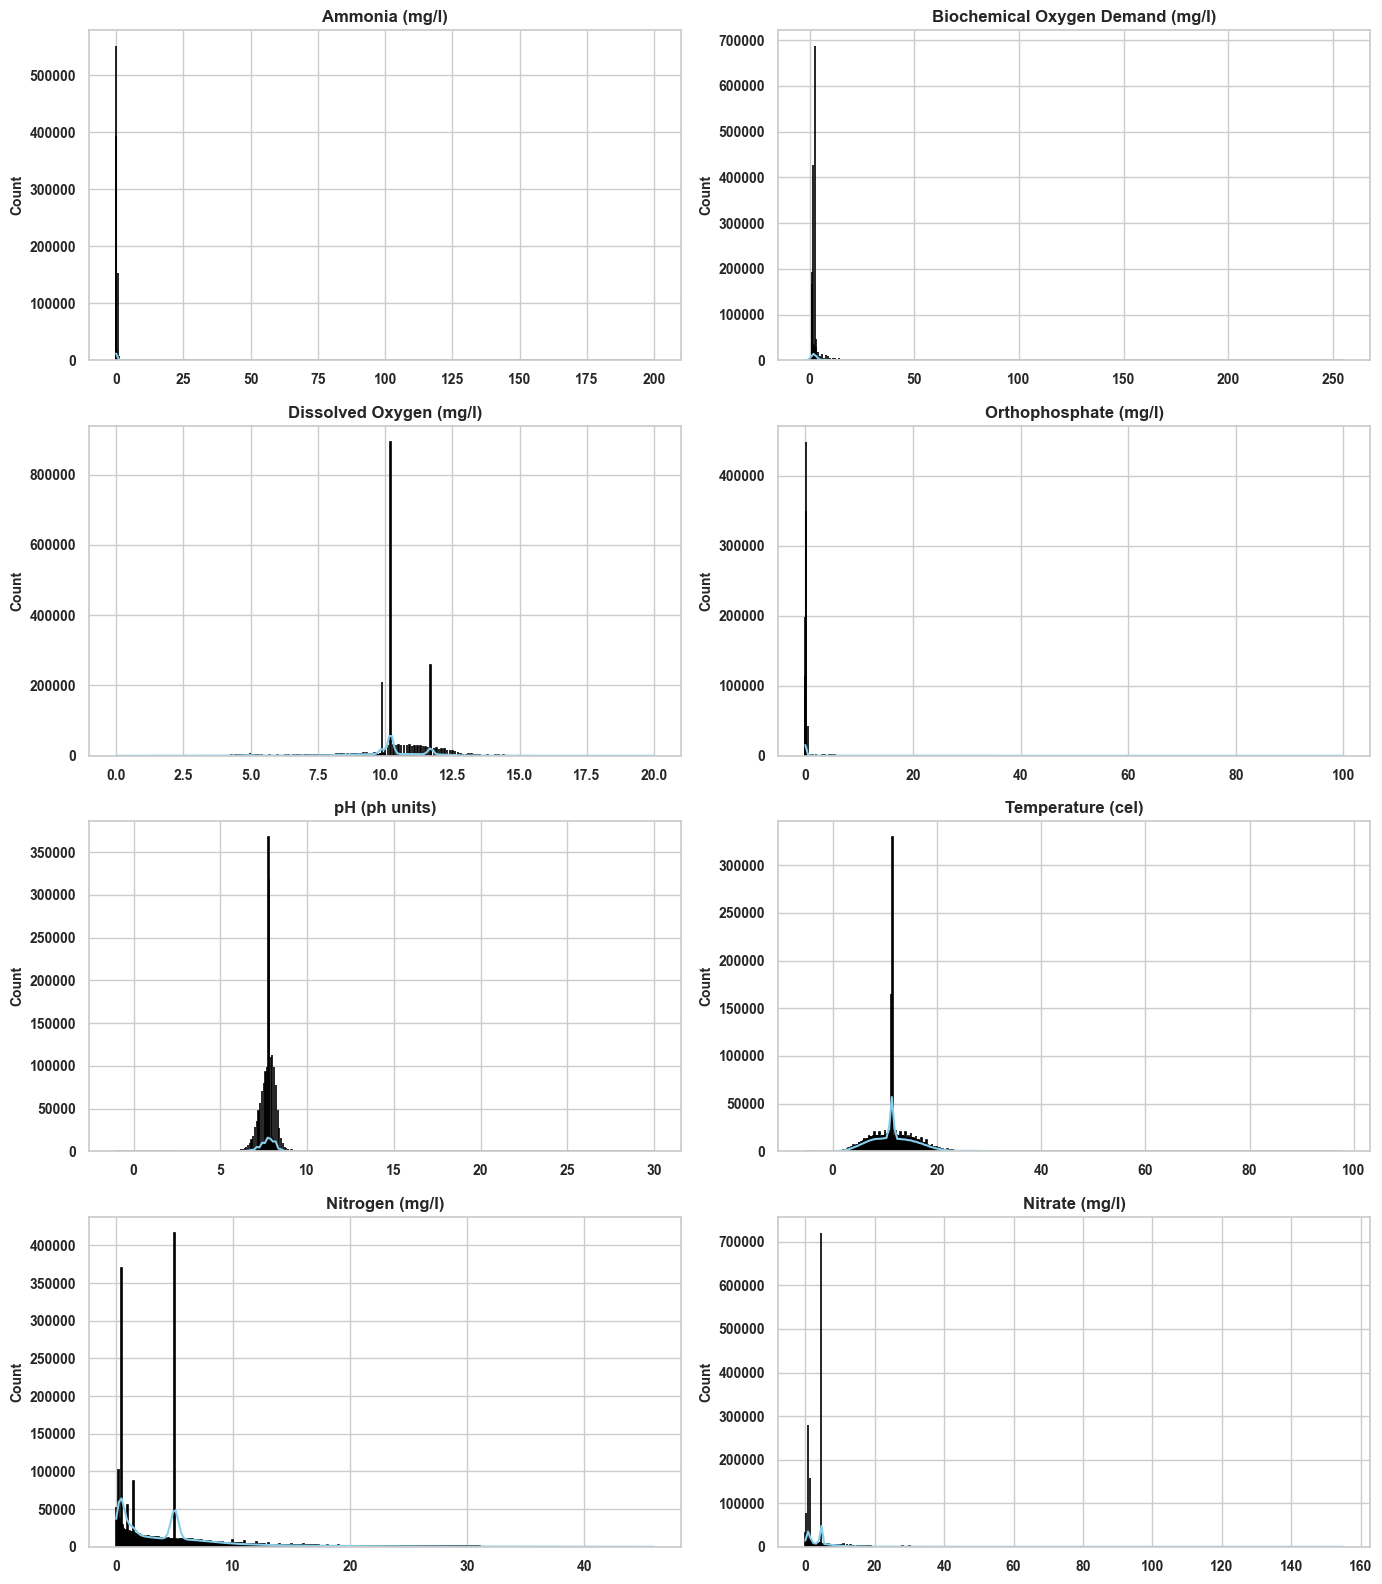

In [16]:
features = [
    "Ammonia (mg/l)", 
    "Biochemical Oxygen Demand (mg/l)",
    "Dissolved Oxygen (mg/l)", 
    "Orthophosphate (mg/l)",
    "pH (ph units)", 
    "Temperature (cel)", 
    "Nitrogen (mg/l)", 
    "Nitrate (mg/l)"
]

n_rows = 4
n_cols = 2

plt.figure(figsize=(14, 16))
sns.set_theme(style="whitegrid")

for i, col in enumerate(features, 1):    
    plt.subplot(n_rows, n_cols, i)
    
    ax = sns.histplot(
        df[col],
        kde=True,
        color="skyblue",
        edgecolor="black",
        linewidth=1.2
    )
    
 
    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_xlabel("")  
    ax.set_ylabel("Count", fontsize=10, fontweight="bold")
    
 
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    for label in ax.get_yticklabels():
        label.set_fontweight("bold")
    for label in ax.get_xticklabels():
        label.set_fontweight("bold")

plt.tight_layout()   
plt.show()


In [17]:
 
valid_ranges = {
    "Ammonia (mg/l)": (0, 20),
    "Biochemical Oxygen Demand (mg/l)": (0, 50),
    "Dissolved Oxygen (mg/l)": (2, 30),
    "Orthophosphate (mg/l)": (0, 10),
    "pH (ph units)": (4, 11),
    "Temperature (cel)": (0, 60),
    "Nitrogen (mg/l)": (0, 50),
    "Nitrate (mg/l)": (0, 100),
    "CCME_Values": (0, 100)
}
mask_valid = pd.Series(True, index=df.index)
for col, (low, high) in valid_ranges.items():
    mask_valid &= df[col].between(low, high, inclusive="both")
df_clean = df[mask_valid].copy()
print("Before cleaning:", df.shape[0], "rows")
print("After cleaning:", df_clean.shape[0], "rows")
print("Removed:", df.shape[0] - df_clean.shape[0], "illogical rows")

Before cleaning: 2827977 rows
After cleaning: 2734630 rows
Removed: 93347 illogical rows


In [18]:
df_clean

,Country,Area,Waterbody Type,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),Nitrate (mg/l),CCME_Values,CCME_WQI,Year,Month
0,Canada,SE649035-145565,River,1974-01-12,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,11.73155,100.0,Excellent,1974,1
1,Canada,SE649035-145565,River,1975-01-12,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,11.82009,100.0,Excellent,1975,1
2,Canada,SE649035-145565,River,1976-01-12,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,14.87472,100.0,Excellent,1976,1
3,Canada,SE649035-145565,River,1977-01-12,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,15.89293,100.0,Excellent,1977,1
4,Canada,SE649035-145565,River,1978-01-12,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,15.22888,100.0,Excellent,1978,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827972,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2022-06-21,0.024000,1.40,4.2930,0.025000,7.90000,16.200,0.370000,0.37000,100.0,Excellent,2022,6
2827973,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2022-09-28,0.038000,1.40,4.4955,0.025000,7.90000,11.400,0.540000,0.54000,100.0,Excellent,2022,9
2827974,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2022-11-29,0.035000,1.40,4.4640,0.016000,7.60000,6.200,0.800000,0.79000,100.0,Excellent,2022,11
2827975,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2023-02-07,0.046000,1.40,4.1760,0.012000,8.00000,7.800,0.950000,1.30000,100.0,Excellent,2023,2


In [19]:
df_clean = df_clean.drop_duplicates()
print("Number of rows after removing duplicates:", df_clean.shape[0])

Number of rows after removing duplicates: 2724675


In [20]:
df_clean['CCME_WQI'] = df_clean['CCME_WQI'].replace({'Marginal': 'Non-Potable Water', 'Poor': 'Non-Potable Water'}) 

C:\Users\O\AppData\Local\Temp\ipykernel_4824\1894763958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['CCME_WQI'] = df_clean['CCME_WQI'].replace({'Marginal': 'Non-Potable Water', 'Poor': 'Non-Potable Water'})


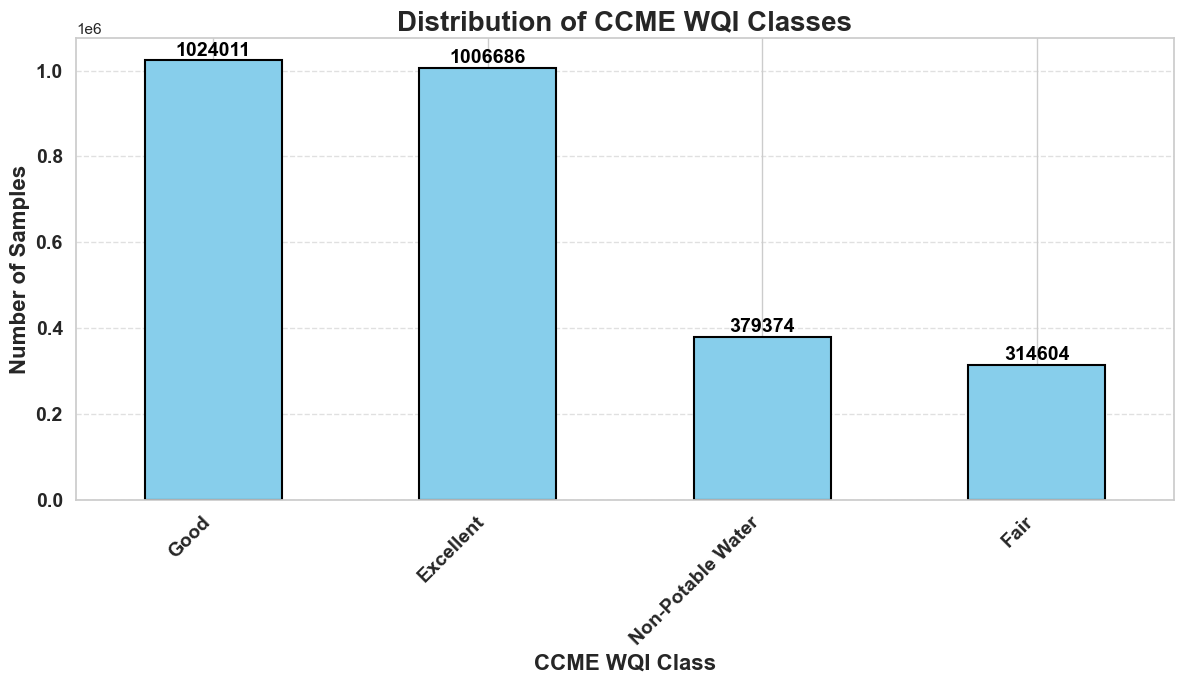

In [21]:
distribution = df_clean["CCME_WQI"].value_counts()
plt.figure(figsize=(12, 7))  
ax = distribution.plot(
    kind="bar",
    color="skyblue",
    edgecolor="black",
    linewidth=1.5
)
ax.set_title(
    "Distribution of CCME WQI Classes",
    fontsize=20,
    fontweight="bold"
)
ax.set_xlabel("CCME WQI Class", fontsize=16, fontweight="bold")
ax.set_ylabel("Number of Samples", fontsize=16, fontweight="bold")
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight("bold")
    label.set_rotation(45)
    label.set_ha("right")
for label in ax.get_yticklabels():
    label.set_fontweight("bold")

for i, v in enumerate(distribution.values):
    ax.text(
        i, v + max(distribution.values)*0.01,   
        str(v),
        ha='center',
        fontsize=14,
        fontweight='bold',
        color='black'
    )
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [22]:
 
df_clean['Waterbody Type'] = df_clean['Waterbody Type'].replace({
    'Marine': 'Coastal/Marine',
    'Sea Water': 'Coastal/Marine',
    'Coastal': 'Coastal/Marine',
    'Estuarine': 'Coastal/Marine',
    'Sewage': 'Wastewater',
    'Effluent': 'Wastewater',
    'Canal': 'Artificial',
    'Drainage': 'Artificial',
    'Bay': 'Minor Waterbodies',
    'Artificial': 'Minor Waterbodies',
    'Transitional': 'Minor Waterbodies'
})
 
df_encoded = pd.get_dummies(df_clean, columns=['Waterbody Type'],dtype="int")

C:\Users\O\AppData\Local\Temp\ipykernel_4824\3796044872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Waterbody Type'] = df_clean['Waterbody Type'].replace({


In [23]:
df_clean['Waterbody Type'].value_counts()

Waterbody Type
River                1819056
Wastewater            567289
Lake                  146316
Coastal/Marine        105160
Minor Waterbodies      49613
Artificial             37241
Name: count, dtype: int64

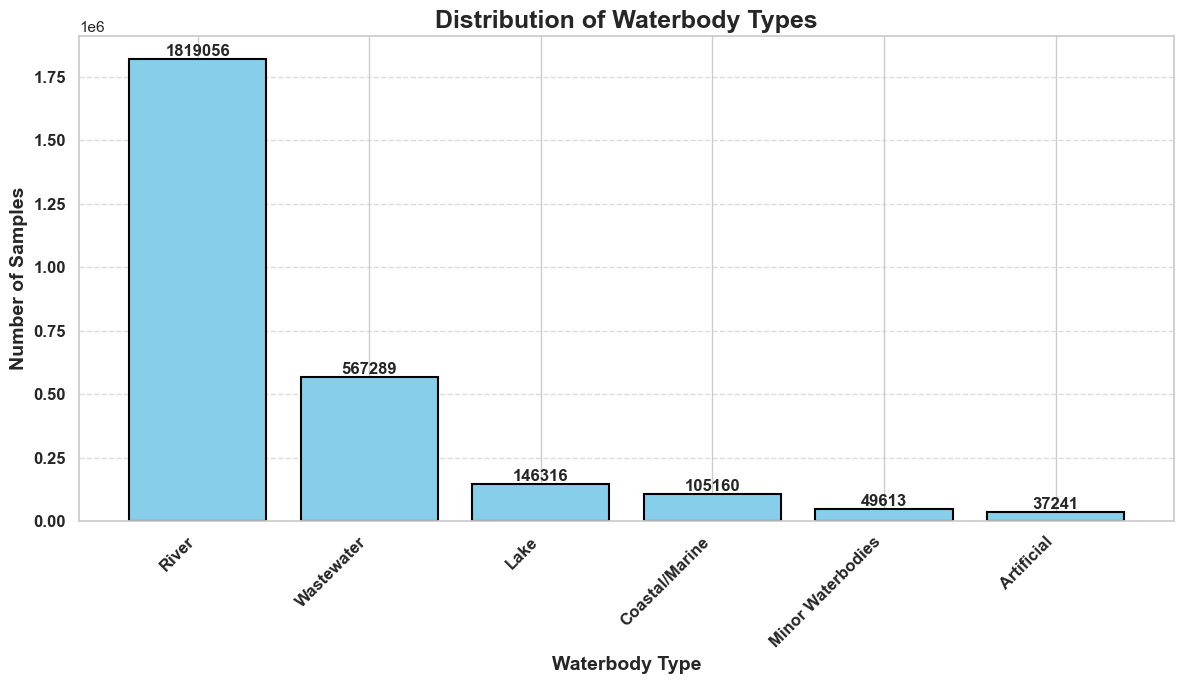

In [24]:
distribution = df_clean['Waterbody Type'].value_counts()
plt.figure(figsize=(12, 7))
bars = plt.bar(distribution.index, distribution.values, color='skyblue', edgecolor='black', linewidth=1.5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Distribution of Waterbody Types', fontsize=18, fontweight='bold')
plt.xlabel('Waterbody Type', fontsize=14, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 

In [25]:
df_encoded

,Country,Area,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),...,CCME_Values,CCME_WQI,Year,Month,Waterbody Type_Artificial,Waterbody Type_Coastal/Marine,Waterbody Type_Lake,Waterbody Type_Minor Waterbodies,Waterbody Type_River,Waterbody Type_Wastewater
0,Canada,SE649035-145565,1974-01-12,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,...,100.0,Excellent,1974,1,0,0,0,0,1,0
1,Canada,SE649035-145565,1975-01-12,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,...,100.0,Excellent,1975,1,0,0,0,0,1,0
2,Canada,SE649035-145565,1976-01-12,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,...,100.0,Excellent,1976,1,0,0,0,0,1,0
3,Canada,SE649035-145565,1977-01-12,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,...,100.0,Excellent,1977,1,0,0,0,0,1,0
4,Canada,SE649035-145565,1978-01-12,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,...,100.0,Excellent,1978,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827972,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2022-06-21,0.024000,1.40,4.2930,0.025000,7.90000,16.200,0.370000,...,100.0,Excellent,2022,6,0,0,0,0,1,0
2827973,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2022-09-28,0.038000,1.40,4.4955,0.025000,7.90000,11.400,0.540000,...,100.0,Excellent,2022,9,0,0,0,0,1,0
2827974,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2022-11-29,0.035000,1.40,4.4640,0.016000,7.60000,6.200,0.800000,...,100.0,Excellent,2022,11,0,0,0,0,1,0
2827975,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2023-02-07,0.046000,1.40,4.1760,0.012000,8.00000,7.800,0.950000,...,100.0,Excellent,2023,2,0,0,0,0,1,0


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class_order = ["Non-Potable Water", "Fair", "Good", "Excellent"]
cat_type = pd.CategoricalDtype(categories=class_order, ordered=True)
y = df_encoded["CCME_WQI"]
y_int = y.astype(cat_type).cat.codes.values

print("class_order, cat_type, device were successfully defined")
print(f"Number of categories:{len(class_order)}")
print(f"Distribution of primary categories: \n{pd.Series(y_int).value_counts()}")

Using device: cuda
class_order, cat_type, device were successfully defined
Number of categories:4
Distribution of primary categories: 
2    1024011
3    1006686
0     379374
1     314604
Name: count, dtype: int64


In [27]:

df_encoded['Date'] = pd.to_datetime(df_encoded['Date'], dayfirst=True, errors='coerce')
df_encoded = df_encoded.sort_values(by=['Area', 'Date']).reset_index(drop=True)
unique_areas = df_encoded['Area'].unique()
np.random.seed(42) 
np.random.shuffle(unique_areas)
train_size = int(len(unique_areas) * 0.7)
val_size   = int(len(unique_areas) * 0.15)

train_areas = unique_areas[:train_size]
val_areas   = unique_areas[train_size:train_size + val_size]
test_areas  = unique_areas[train_size + val_size:]

df_train_final = df_encoded[df_encoded['Area'].isin(train_areas)].copy()
df_val_final   = df_encoded[df_encoded['Area'].isin(val_areas)].copy()
df_test_final  = df_encoded[df_encoded['Area'].isin(test_areas)].copy()

print(f"Training: {len(df_train_final)} records  ({len(train_areas)} areas)")
print(f" Validation: {len(df_val_final)} records  ({len(val_areas)} areas)")
print(f" Testing: {len(df_test_final)} records  ({len(test_areas)} areas)")

 
def extract_X_y(df):
    X_df = df.drop(columns=["CCME_WQI", "Country", "Area", "Date", "Year", "CCME_Values"])
    y_df = df["CCME_WQI"].astype(cat_type).cat.codes.values
    return X_df, y_df

X_train, y_train = extract_X_y(df_train_final)
X_val,   y_val   = extract_X_y(df_val_final)
X_test,  y_test  = extract_X_y(df_test_final)

 
X_train.columns = [col.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '') for col in X_train.columns]
X_val.columns   = X_train.columns
X_test.columns  = X_train.columns
 
num_features = ["Ammonia_mg_l", "Biochemical_Oxygen_Demand_mg_l", "Dissolved_Oxygen_mg_l", 
                "Orthophosphate_mg_l", "pH_ph_units", "Temperature_cel", 
                "Nitrogen_mg_l", "Nitrate_mg_l"]
cat_features = [col for col in X_train.columns if col not in num_features]

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('pw', PowerTransformer(method='yeo-johnson')),
        ('sc', StandardScaler())
    ]), num_features),
    ('cat', 'passthrough', cat_features)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

Training: 1931177 records  (42019 areas)
 Validation: 390568 records  (9004 areas)
 Testing: 402930 records  (9005 areas)


In [28]:
def create_sequences_fast(X_proc, y_data, areas_df, seq_length=5,stride=3):
    all_x, all_y = [], []
    areas_values = areas_df['Area'].values
    y_values = y_data.values if hasattr(y_data, 'values') else y_data
    unique_areas = areas_df['Area'].unique()
    pbar = tqdm(unique_areas, desc="Creating Augmented Sequences", unit="area")
    
    for area in pbar:
        mask = (areas_values == area)
        X_area = X_proc[mask]
        y_area = y_values[mask]
        
        if len(X_area) > seq_length:
            for start in range(0, len(X_area) - seq_length + 1, stride):
                all_x.append(X_area[start:start + seq_length])
                all_y.append(y_area[start + seq_length - 1])
    
    pbar.close()
    return np.array(all_x, dtype=np.float32), np.array(all_y, dtype=np.int64)
 
print("Starting sequence generation...")

start_time = time.time()

X_train_seq, y_train_seq = create_sequences_fast(
    X_train_proc, y_train, df_train_final, 
    seq_length=7,     
    stride=3          
)

X_val_seq, y_val_seq = create_sequences_fast(
    X_val_proc, y_val, df_val_final, 
    seq_length=7, 
    stride=1           
)

X_test_seq, y_test_seq = create_sequences_fast(
    X_test_proc, y_test, df_test_final, 
    seq_length=7, 
    stride=1
)

print(f"Conversion completed in {time.time() - start_time:.2f} seconds")

class_weights_np = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

print("\nFinal class weights:")

for cls_idx, w in enumerate(class_weights):
    print(f"{cls_idx} ({class_order[cls_idx]}): {w:.4f}")

Starting sequence generation...


Creating Augmented Sequences: 100%|██████████| 9005/9005 [01:09<00:00, 130.27area/s]


Conversion completed in 1692.54 seconds

Final class weights:
0 (Non-Potable Water): 1.9196
1 (Fair): 2.2309
2 (Good): 0.6616
3 (Excellent): 0.6582


In [29]:
X_train_t = torch.FloatTensor(X_train_seq).to(device)
y_train_t = torch.LongTensor(y_train_seq).to(device)
X_val_t = torch.FloatTensor(X_val_seq).to(device)
y_val_t = torch.LongTensor(y_val_seq).to(device)
X_test_t = torch.FloatTensor(X_test_seq).to(device)
y_test_t = torch.LongTensor(y_test_seq).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

In [30]:

class SelfAttention(nn.Module):
  
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.context = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, x):
        energy = torch.tanh(self.attn(x))            
        scores = self.context(energy).squeeze(-1)  
        alpha = torch.softmax(scores, dim=1)         
        context_vector = torch.sum(x * alpha.unsqueeze(-1), dim=1)  
        return context_vector, alpha

class SA_LSTM_LOADEST_Classifier(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size=128,
        num_layers=2,
        num_classes=4,
        dropout=0.2,
        bidirectional=False
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )
        
        lstm_out_dim = hidden_size * (2 if bidirectional else 1)
        
        self.attention = SelfAttention(lstm_out_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_out_dim, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context, attn_weights = self.attention(lstm_out)
        context = self.dropout(context)
        logits = self.fc(context)
        return logits   

 
input_size = X_train_seq.shape[2]   
hidden_size = 128
num_layers = 2
num_classes = len(class_order)       

model = SA_LSTM_LOADEST_Classifier(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=0.2,
    bidirectional=False
).to(device)

print(model)   

SA_LSTM_LOADEST_Classifier(
  (lstm): LSTM(15, 128, num_layers=2, batch_first=True, dropout=0.2)
  (attention): SelfAttention(
    (attn): Linear(in_features=128, out_features=128, bias=True)
    (context): Linear(in_features=128, out_features=1, bias=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


In [ ]:
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")

optimizer = optim.AdamW(
    model.parameters(),
    lr=0.0005,
    weight_decay=1e-5,
    betas=(0.9, 0.999),
    eps=1e-8
)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True,
    min_lr=1e-6
)

num_epochs = 30
patience = 12
min_delta = 0.001

 
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_bal_accs, val_bal_accs = [], []

best_val_bal_acc = 0.0
patience_counter = 0
best_epoch = 0

print("=" * 110)
print(f"{'Epoch':<6} | {'Train Loss':<12} | {'Train Acc':<10} | {'Train Bal.Acc':<14} | "
      f"{'Val Loss':<12} | {'Val Acc':<10} | {'Val Bal.Acc':<14} | {'LR':<10} | {'Best':<6}")
print("-" * 110)

 
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_preds_list = []
    train_targets_list = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False, ncols=100)
    for batch_x, batch_y in loop:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item() * batch_y.size(0)
        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == batch_y).sum().item()
        train_total += batch_y.size(0)

        train_preds_list.extend(preds.cpu().numpy())
        train_targets_list.extend(batch_y.cpu().numpy())

    train_loss /= train_total
    train_acc = 100. * train_correct / train_total
    train_bal_acc = 100. * balanced_accuracy_score(train_targets_list, train_preds_list)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_bal_accs.append(train_bal_acc)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_preds_list = []
    val_targets_list = []

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_x)
            loss = criterion(logits, batch_y)

            val_loss += loss.item() * batch_y.size(0)
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)

            val_preds_list.extend(preds.cpu().numpy())
            val_targets_list.extend(batch_y.cpu().numpy())

    val_loss /= val_total
    val_acc = 100. * val_correct / val_total
    val_bal_acc = 100. * balanced_accuracy_score(val_targets_list, val_preds_list)

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_bal_accs.append(val_bal_acc)

    current_lr = optimizer.param_groups[0]['lr']

     
    is_best = val_bal_acc > best_val_bal_acc + min_delta
    if is_best:
        best_val_bal_acc = val_bal_acc
        best_epoch = epoch + 1
        patience_counter = 0

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_bal_acc': val_bal_acc,
        }, 'best_sa_lstm_loadest_classifier.pth')

        print(f"  → **New best** (Val Bal.Acc: {val_bal_acc:.2f}%)")
    else:
        patience_counter += 1

    print(f"{epoch+1:<6} | {train_loss:<12.4f} | {train_acc:<10.2f} | {train_bal_acc:<14.2f} | "
          f"{val_loss:<12.4f} | {val_acc:<10.2f} | {val_bal_acc:<14.2f} | {current_lr:<10.2e}")

    scheduler.step(val_bal_acc)

    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs "
              f"(no improvement ≥ {min_delta*100:.2f}% for {patience} epochs)")
        break

print("=" * 110)
print(f"Training finished. Best Validation Balanced Accuracy: {best_val_bal_acc:.2f}% at epoch {best_epoch}")


d:\master\Dataset\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  | Train Loss   | Train Acc  | Train Bal.Acc  | Val Loss     | Val Acc    | Val Bal.Acc    | LR         | Best  
--------------------------------------------------------------------------------------------------------------


  → **New best** (Val Bal.Acc: 94.30%)
1      | 0.2616       | 90.02      | 89.38          | 0.1341       | 94.60      | 94.30          | 5.00e-04  


  → **New best** (Val Bal.Acc: 94.98%)
2      | 0.1531       | 94.28      | 93.63          | 0.1106       | 95.19      | 94.98          | 5.00e-04  


  → **New best** (Val Bal.Acc: 95.73%)
3      | 0.1307       | 95.30      | 94.54          | 0.0903       | 96.29      | 95.73          | 5.00e-04  


  → **New best** (Val Bal.Acc: 95.98%)
4      | 0.1191       | 95.82      | 94.99          | 0.0828       | 96.28      | 95.98          | 5.00e-04  


  → **New best** (Val Bal.Acc: 96.15%)
5      | 0.1118       | 96.15      | 95.29          | 0.0804       | 96.95      | 96.15          | 5.00e-04  


  → **New best** (Val Bal.Acc: 96.30%)
6      | 0.1059       | 96.40      | 95.55          | 0.0756       | 97.04      | 96.30          | 5.00e-04  


7      | 0.1009       | 96.62      | 95.77          | 0.0865       | 96.90      | 95.93          | 5.00e-04  


  → **New best** (Val Bal.Acc: 96.68%)
8      | 0.0980       | 96.77      | 95.92          | 0.0709       | 97.16      | 96.68          | 5.00e-04  


  → **New best** (Val Bal.Acc: 96.69%)
9      | 0.0937       | 96.95      | 96.11          | 0.0690       | 97.05      | 96.69          | 5.00e-04  


10     | 0.0910       | 97.04      | 96.18          | 0.0739       | 97.56      | 96.62          | 5.00e-04  


  → **New best** (Val Bal.Acc: 96.81%)
11     | 0.0887       | 97.19      | 96.32          | 0.0667       | 97.51      | 96.81          | 5.00e-04  


12     | 0.0858       | 97.31      | 96.45          | 0.0720       | 97.21      | 96.71          | 5.00e-04  


  → **New best** (Val Bal.Acc: 96.84%)
13     | 0.0835       | 97.37      | 96.52          | 0.0700       | 97.59      | 96.84          | 5.00e-04  


  → **New best** (Val Bal.Acc: 97.03%)
14     | 0.0821       | 97.47      | 96.62          | 0.0614       | 97.52      | 97.03          | 5.00e-04  


  → **New best** (Val Bal.Acc: 97.26%)
15     | 0.0805       | 97.53      | 96.71          | 0.0559       | 97.84      | 97.26          | 5.00e-04  


16     | 0.0790       | 97.60      | 96.75          | 0.0601       | 97.73      | 97.06          | 5.00e-04  


17     | 0.0785       | 97.63      | 96.79          | 0.0603       | 97.58      | 97.17          | 5.00e-04  


18     | 0.0760       | 97.71      | 96.87          | 0.0588       | 97.86      | 97.24          | 5.00e-04  


19     | 0.0749       | 97.78      | 96.96          | 0.0577       | 97.80      | 97.19          | 5.00e-04  


  → **New best** (Val Bal.Acc: 97.35%)
20     | 0.0627       | 98.14      | 97.41          | 0.0588       | 97.98      | 97.35          | 2.50e-04  


21     | 0.0625       | 98.19      | 97.47          | 0.0607       | 98.11      | 97.14          | 2.50e-04  


  → **New best** (Val Bal.Acc: 97.52%)
22     | 0.0621       | 98.21      | 97.49          | 0.0544       | 98.23      | 97.52          | 2.50e-04  


23     | 0.0608       | 98.28      | 97.58          | 0.0560       | 98.19      | 97.49          | 2.50e-04  


24     | 0.0601       | 98.30      | 97.60          | 0.0538       | 98.15      | 97.45          | 2.50e-04  


25     | 0.0603       | 98.31      | 97.61          | 0.0647       | 97.91      | 97.07          | 2.50e-04  


26     | 0.0596       | 98.35      | 97.68          | 0.0628       | 97.82      | 97.31          | 2.50e-04  


  → **New best** (Val Bal.Acc: 97.79%)
27     | 0.0513       | 98.57      | 97.96          | 0.0483       | 98.44      | 97.79          | 1.25e-04  


  → **New best** (Val Bal.Acc: 97.85%)
28     | 0.0511       | 98.62      | 98.02          | 0.0494       | 98.41      | 97.85          | 1.25e-04  


29     | 0.0502       | 98.64      | 98.05          | 0.0553       | 98.39      | 97.53          | 1.25e-04  


30     | 0.0497       | 98.67      | 98.07          | 0.0527       | 98.45      | 97.71          | 1.25e-04  
Training finished. Best Validation Balanced Accuracy: 97.85% at epoch 28


In [32]:
print("\nFinal testing on Test Set...\n")
 
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
test_preds = []
test_targets = []
test_preds_probs = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        test_loss += loss.item()
        preds = outputs.argmax(1)
        test_correct += (preds == batch_y).sum().item()
        test_total += batch_y.size(0)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())
        probs = torch.softmax(outputs, dim=1)
        test_preds_probs.extend(probs.cpu().numpy())

test_acc = 100 * test_correct / test_total
test_loss_avg = test_loss / len(test_loader)
test_balanced_acc = 100 * balanced_accuracy_score(test_targets, test_preds)
test_preds_probs = np.array(test_preds_probs)
test_targets_array = np.array(test_targets)

print("=" * 80)
print("Final test results:")
print("=" * 80)
print(f"    Test Loss:             {test_loss_avg:.4f}")
print(f"    Test Accuracy:         {test_acc:.2f}%")
print(f"    Test Balanced Acc:     {test_balanced_acc:.2f}%")
print("=" * 80)

 


Final testing on Test Set...

Final test results:
    Test Loss:             0.0495
    Test Accuracy:         98.53%
    Test Balanced Acc:     97.69%


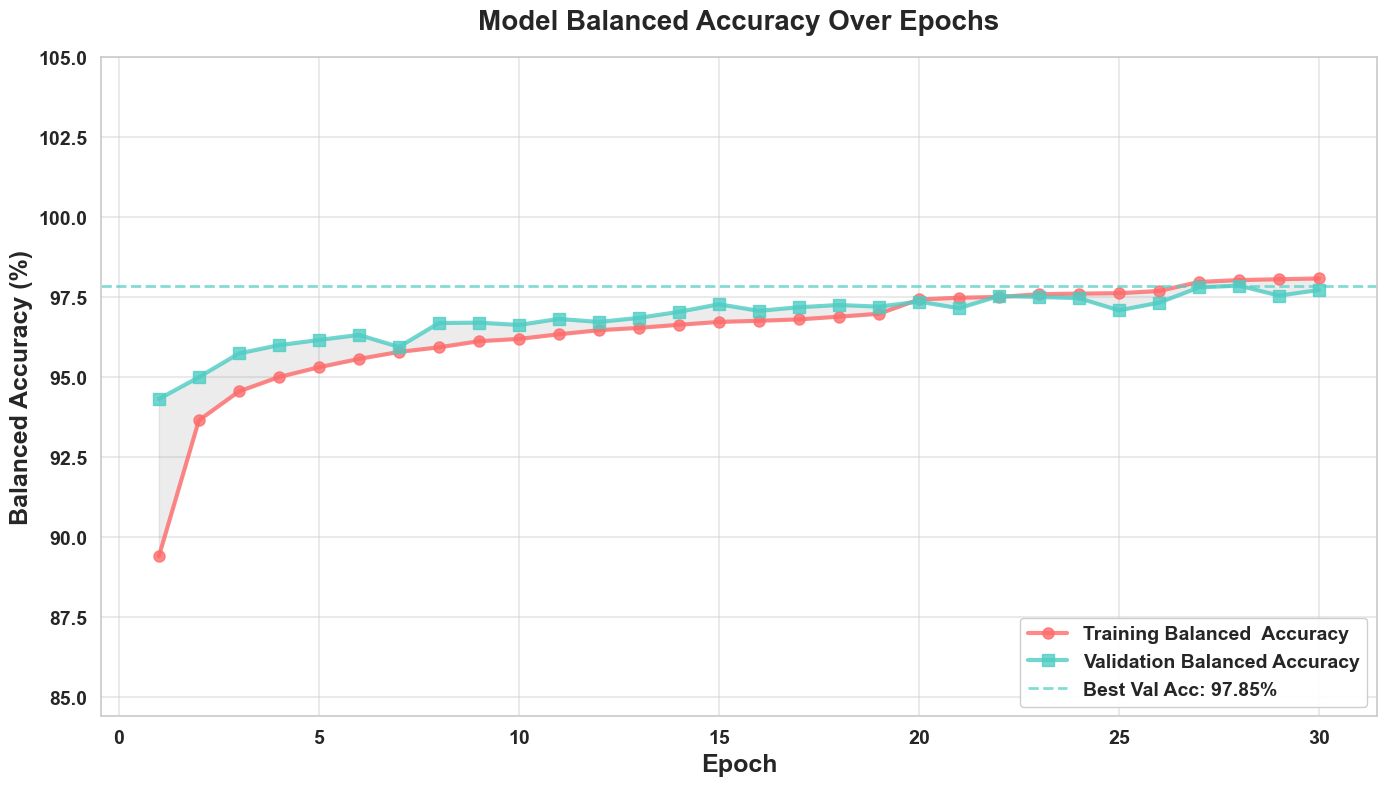

In [33]:
 


fig, ax = plt.subplots(figsize=(14, 8))
epochs_arr = np.arange(1, len(train_bal_accs) + 1)
ax.plot(epochs_arr, train_bal_accs, marker='o', linewidth=3, 
        markersize=8, label='Training Balanced  Accuracy', color='#FF6B6B', alpha=0.8)
ax.plot(epochs_arr, val_bal_accs, marker='s', linewidth=3, 
        markersize=8, label='Validation Balanced Accuracy', color='#4ECDC4', alpha=0.8)

ax.fill_between(epochs_arr, train_bal_accs, val_bal_accs, alpha=0.15, color='gray')
ax.axhline(y=np.max(val_bal_accs), color='#4ECDC4', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Best Val Acc: {np.max(val_bal_accs):.2f}%')
ax.set_xlabel('Epoch', fontsize=18, fontweight='bold')
ax.set_ylabel('Balanced Accuracy (%)', fontsize=18, fontweight='bold')
ax.set_title('Model Balanced Accuracy Over Epochs', fontsize=20, fontweight='bold', pad=20)
ax.legend(fontsize=14, loc='lower right', framealpha=0.95)
ax.grid(True, alpha=0.4, linewidth=1.5)
ax.set_ylim([min(train_bal_accs) - 5, 105])
ax.tick_params(axis='both', labelsize=14, width=2)   
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontweight('bold')

plt.tight_layout()
plt.show()

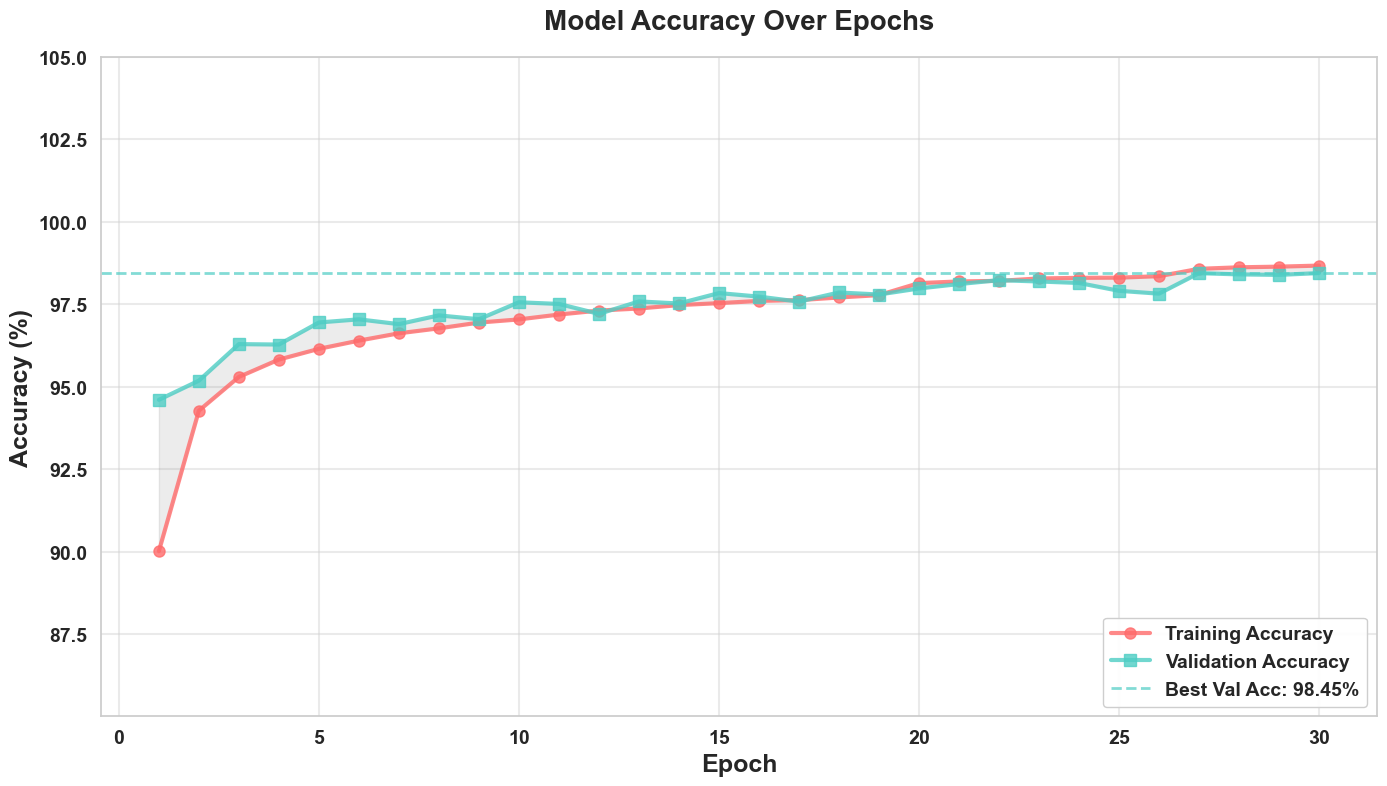

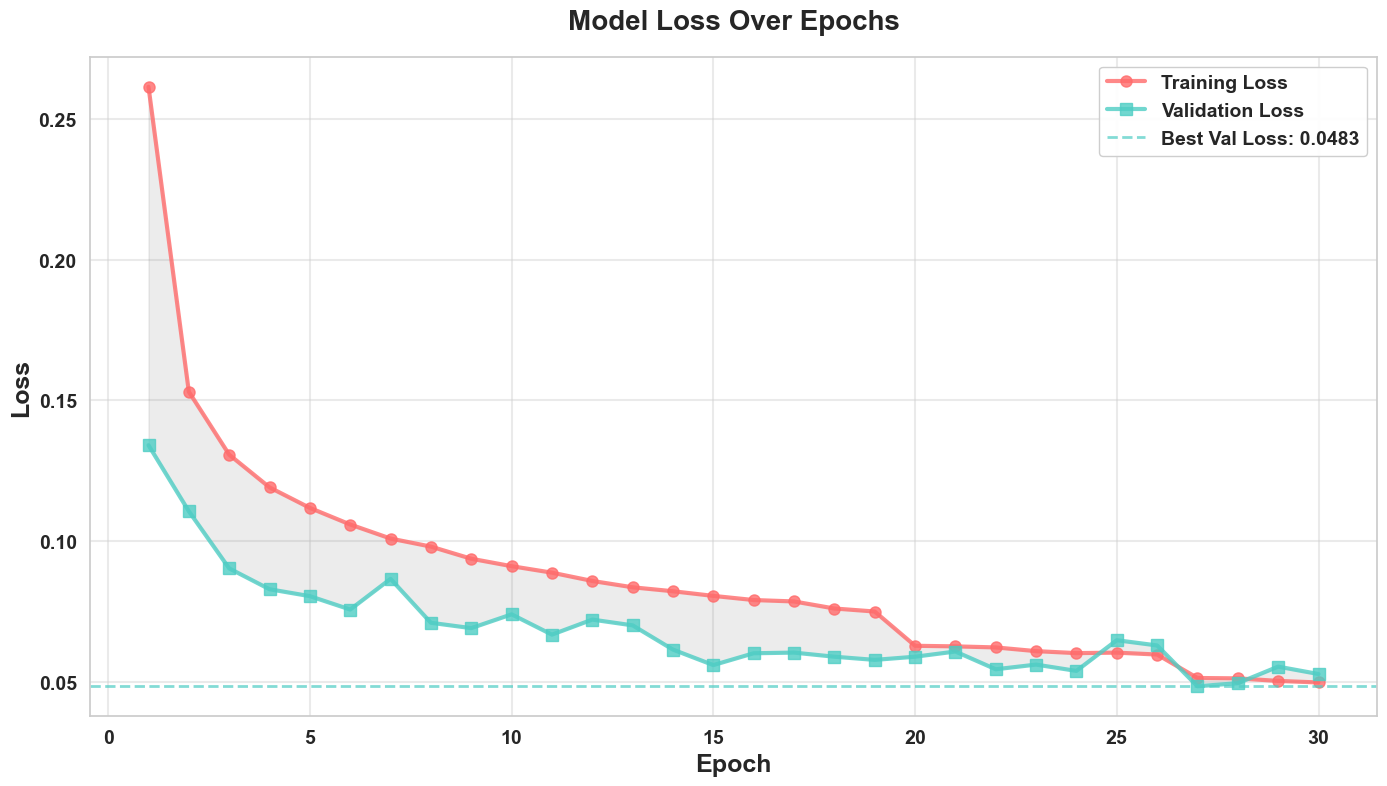

In [34]:
 
fig, ax = plt.subplots(figsize=(14, 8))
epochs_arr = np.arange(1, len(train_accs) + 1)
ax.plot(epochs_arr, train_accs, marker='o', linewidth=3, 
        markersize=8, label='Training Accuracy', color='#FF6B6B', alpha=0.8)
ax.plot(epochs_arr, val_accs, marker='s', linewidth=3, 
        markersize=8, label='Validation Accuracy', color='#4ECDC4', alpha=0.8)

ax.fill_between(epochs_arr, train_accs, val_accs, alpha=0.15, color='gray')
ax.axhline(y=np.max(val_accs), color='#4ECDC4', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Best Val Acc: {np.max(val_accs):.2f}%')
ax.set_xlabel('Epoch', fontsize=18, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=18, fontweight='bold')
ax.set_title('Model Accuracy Over Epochs', fontsize=20, fontweight='bold', pad=20)
ax.legend(fontsize=14, loc='lower right', framealpha=0.95)
ax.grid(True, alpha=0.4, linewidth=1.5)
ax.set_ylim([min(train_accs) - 5, 105])
ax.tick_params(axis='both', labelsize=14, width=2)   
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontweight('bold')

plt.tight_layout()
plt.show()

 


fig, ax = plt.subplots(figsize=(14, 8))
epochs_arr = np.arange(1, len(train_losses) + 1)

ax.plot(epochs_arr, train_losses, marker='o', linewidth=3, 
        markersize=8, label='Training Loss', color='#FF6B6B', alpha=0.8)
ax.plot(epochs_arr, val_losses, marker='s', linewidth=3, 
        markersize=8, label='Validation Loss', color='#4ECDC4', alpha=0.8)

ax.fill_between(epochs_arr, train_losses, val_losses, alpha=0.15, color='gray')

ax.axhline(y=np.min(val_losses), color='#4ECDC4', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Best Val Loss: {np.min(val_losses):.4f}')

ax.set_xlabel('Epoch', fontsize=18, fontweight='bold')
ax.set_ylabel('Loss', fontsize=18, fontweight='bold')
ax.set_title('Model Loss Over Epochs', fontsize=20, fontweight='bold', pad=20)
ax.legend(fontsize=14, loc='upper right', framealpha=0.95)
ax.grid(True, alpha=0.4, linewidth=1.5)
ax.tick_params(axis='both', labelsize=14, width=2)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontweight('bold')


plt.tight_layout()
plt.show()

 

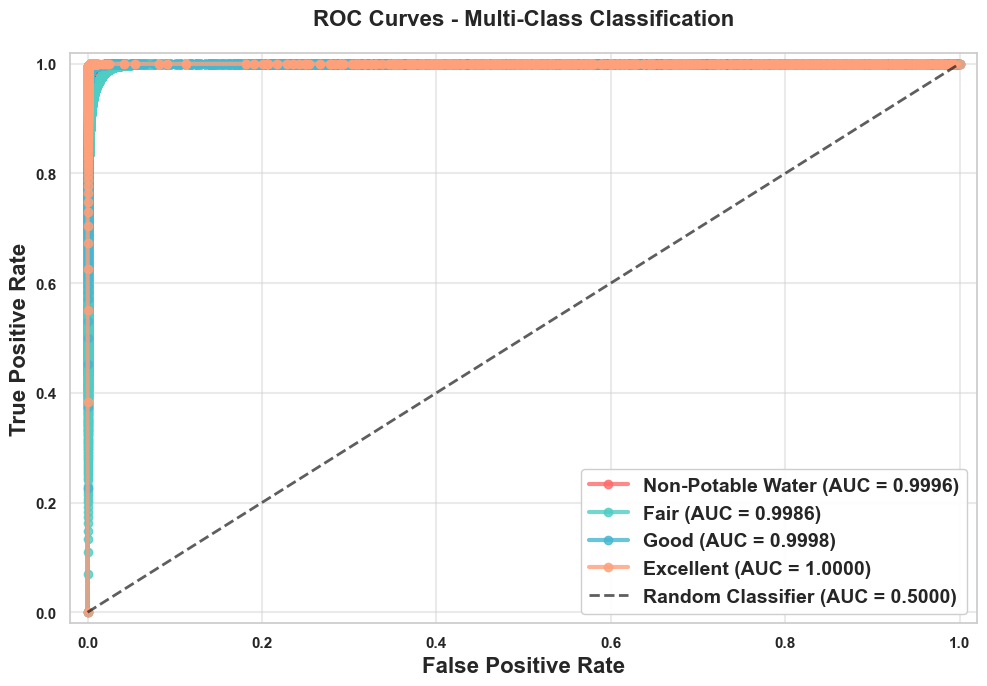

In [35]:

y_test_bin = label_binarize(test_targets_array, classes=[0, 1, 2, 3])

fig, ax = plt.subplots(figsize=(10, 7))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
roc_auc_scores = []

for i, class_name in enumerate(class_order):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_preds_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)
    
    ax.plot(fpr, tpr, linewidth=3, label=f'{class_name} (AUC = {roc_auc:.4f})', 
            color=colors[i], marker='o', markersize=6, alpha=0.8)

ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)', alpha=0.7)

ax.set_xlabel('False Positive Rate', fontsize=16, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=16, fontweight='bold')
ax.set_title('ROC Curves - Multi-Class Classification', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=14, loc='lower right', framealpha=0.95)
ax.grid(True, alpha=0.4, linewidth=1.5)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
plt.tight_layout()
plt.show()

 

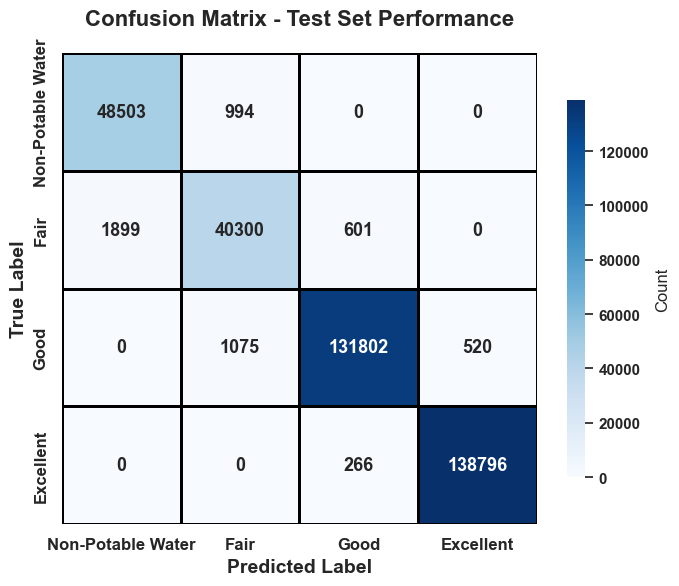

In [36]:
cm = confusion_matrix(test_targets, test_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_order,
    yticklabels=class_order,
    cbar_kws={'label': 'Count', 'shrink': 0.8},
    ax=ax,
    annot_kws={'fontsize': 13, 'weight': 'bold'},    
    linewidths=2,
    linecolor='black'
)
ax.set_title('Confusion Matrix - Test Set Performance', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

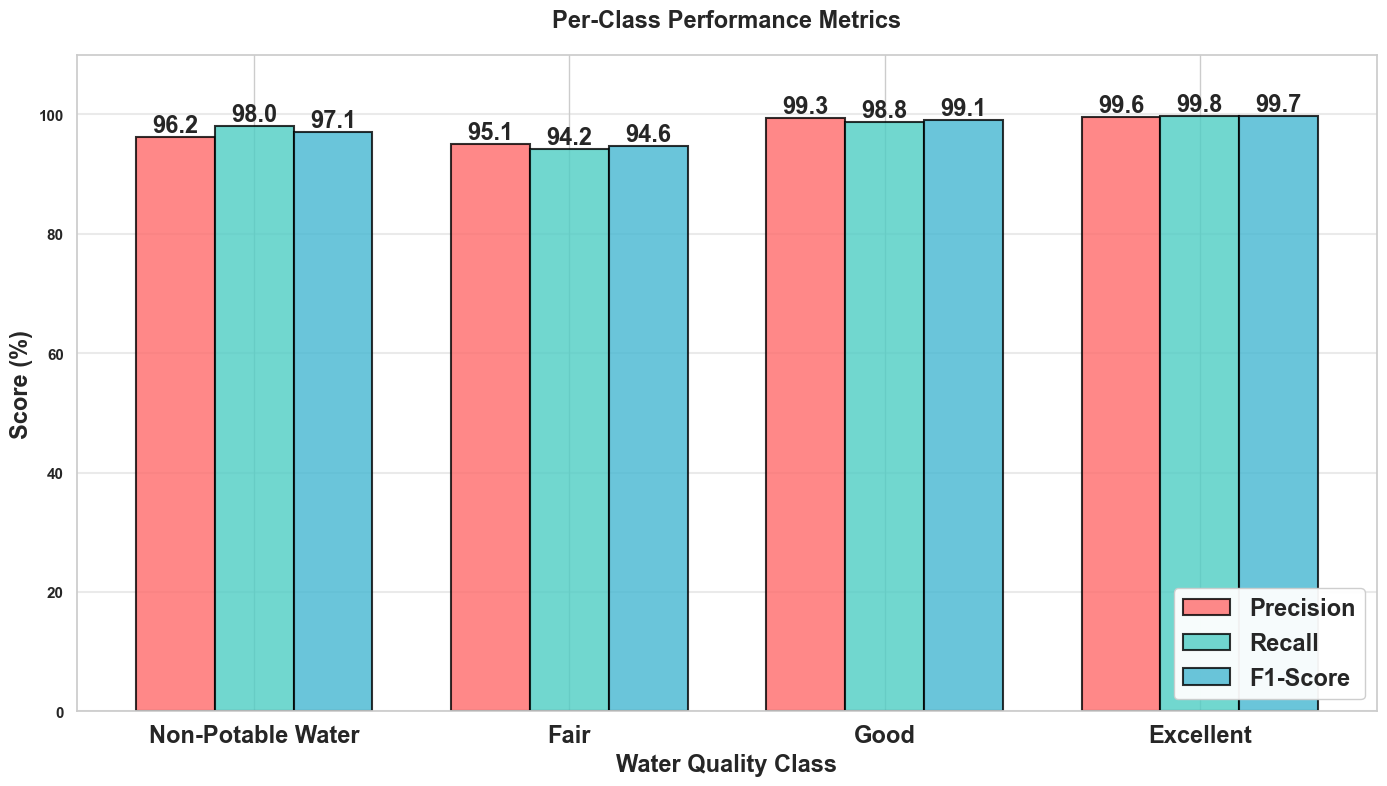

In [37]:
 

precision_per_class = precision_score(test_targets, test_preds, average=None, zero_division=0)
recall_per_class = recall_score(test_targets, test_preds, average=None, zero_division=0)
f1_per_class = f1_score(test_targets, test_preds, average=None, zero_division=0)

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(class_order))
width = 0.25

bars1 = ax.bar(x - width, precision_per_class * 100, width, label='Precision', 
               color='#FF6B6B', edgecolor='black', linewidth=1.5, alpha=0.8)
bars2 = ax.bar(x, recall_per_class * 100, width, label='Recall', 
               color='#4ECDC4', edgecolor='black', linewidth=1.5, alpha=0.8)
bars3 = ax.bar(x + width, f1_per_class * 100, width, label='F1-Score', 
               color='#45B7D1', edgecolor='black', linewidth=1.5, alpha=0.8)

ax.set_xlabel('Water Quality Class', fontsize=17, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=17, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=17, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(class_order, fontsize=17, fontweight='bold')
ax.legend(fontsize=17, loc='lower right', framealpha=0.95)
ax.set_ylim([0, 110])
ax.grid(axis='y', alpha=0.4, linewidth=1.5)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=17, fontweight='bold')

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

 

In [38]:
 
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(test_targets, test_preds, average='weighted')
recall    = recall_score(test_targets, test_preds, average='weighted')
f1        = f1_score(test_targets, test_preds, average='weighted')
print("\n" + "=" * 100)
print(" FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 100)

print(f"\n OVERALL METRICS:")
print("-" * 100)
print(f"  • Test Accuracy:           {test_acc * 100:>8.2f}%")
print(f"  • Test Balanced Accuracy:  {test_balanced_acc:>8.2f}%")
print(f"  • Test Loss:               {test_loss_avg:>8.4f}")
print(f"  • Weighted Precision:      {precision * 100:>8.2f}%")
print(f"  • Weighted Recall:         {recall * 100:>8.2f}%")
print(f"  • Weighted F1-Score:       {f1 * 100:>8.2f}%")

print(f"\n ROC-AUC SCORES (Per Class):")
print("-" * 100)
for i, class_name in enumerate(class_order):
    print(f"  • {class_name:<25}: {roc_auc_scores[i]:.4f}")

print(f"\n DETAILED CLASSIFICATION REPORT:")
print("-" * 100)
print(classification_report(test_targets, test_preds, target_names=class_order, digits=4))

print("\n" + "=" * 100)
print("=" * 100)


 FINAL MODEL PERFORMANCE SUMMARY

 OVERALL METRICS:
----------------------------------------------------------------------------------------------------
  • Test Accuracy:            9853.19%
  • Test Balanced Accuracy:     97.69%
  • Test Loss:                 0.0495
  • Weighted Precision:         98.53%
  • Weighted Recall:            98.53%
  • Weighted F1-Score:          98.53%

 ROC-AUC SCORES (Per Class):
----------------------------------------------------------------------------------------------------
  • Non-Potable Water        : 0.9996
  • Fair                     : 0.9986
  • Good                     : 0.9998
  • Excellent                : 1.0000

 DETAILED CLASSIFICATION REPORT:
----------------------------------------------------------------------------------------------------
                   precision    recall  f1-score   support

Non-Potable Water     0.9623    0.9799    0.9710     49497
             Fair     0.9512    0.9416    0.9464     42800
             Good